# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


<b>Objective:-</b>
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import pickle
from tqdm import tqdm
import os

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
sample_data = filtered_data.head(50000) #Sampled amazon fine foood reviews filtered data to 50k datapoints for time effiecieny

# Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=sample_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(sample_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

2
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [12]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'is', 'myself', "that'll", 'both', 'no', 'now', 'yourselves', 'has', "won't", 'of', 'who', 'himself', 's', 'he', 't', 'am', 'only', 'have', 'they', 'below', 'you', 'mustn', 'couldn', 'at', 'about', 'she', 'up', 'ain', 'does', 'hadn', 'doing', 'yours', 'when', 'hers', 'from', 'if', 'yourself', 'off', 'being', 'why', 'nor', 'once', 'our', "hadn't", 're', 'him', 'during', 'more', "shan't", 'too', 'which', 'them', 'a', 'in', 'until', 'then', 'all', 'theirs', 'had', "hasn't", 'where', 'will', 'needn', 'into', 'was', "weren't", 'through', 'her', 'as', 'don', 'that', 'each', 'aren', 'its', 'd', "couldn't", 'hasn', 'doesn', 'be', 'wouldn', 'just', "you've", 'been', 'not', "didn't", "wouldn't", 'before', 'but', 'here', 'against', 'whom', "wasn't", 'or', 'didn', 'i', "aren't", 'this', "mustn't", 'few', 'an', 'while', 'shouldn', 'their', 'under', 'because', 'again', 'did', 'for', 'those', 'it', 'having', 'there', 'down', 'do', "doesn't", 'themselves', 'me', 'should', 'the', 'were', 'y', 'with', 

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8') #snoball stemmer
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_positive_words, f)      # dump data to f
    with open('negitive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_negative_words, f)      # dump data to f

In [14]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

### Sorting dataset based on 'Time' feature

In [15]:
final_reviews = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_reviews.shape

(46071, 12)

### Spliting data 

In [37]:
#split data into train, cross validate and test 
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
X = final_reviews['CleanedText']
Y = final_reviews['Score']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)

In [38]:
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (30867,) (30867,)
X_test, Y_test (15204,) (15204,)
X_tr, Y_tr (20680,) (20680,)
X_cv, Y_cv (10187,) (10187,)


# Logistic Regression with simple CV

In [39]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

## Training Model

In [40]:
from sklearn.linear_model import LogisticRegression
# logistic Regression with penality = 'l1'
def logistic_l1(X_train,X_cv,Y_train,Y_cv):
    best_C=0
    max_roc_auc=-1
    pred_cv = []
    pred_train = []
    C=[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001] 
    for i in C[-19:]:
        logisticl1 = LogisticRegression(C=i,penalty='l1',solver='liblinear')
        logisticl1.fit(X_train,Y_train)
        probs = logisticl1.predict_proba(X_cv)
        prob = logisticl1.predict_proba(X_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(Y_cv,probs)
        auc_score_train = roc_auc_score(Y_train,prob)
        print(i," for CV data auc score is --> ",auc_score_cv," and for train data auc score is --> ",auc_score_train)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        if(max_roc_auc<auc_score_cv):
            max_roc_auc=auc_score_cv
            best_C=i
    print(f"\n Best C Value {best_C} with highest roc_auc Score is {max_roc_auc}")
    sns.set_style("darkgrid")
    plt.xscale('log')
    plt.plot(C, pred_cv,'r-', label = 'CV Data')
    plt.plot(C,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title(r'Auc Score v/s $\lambda$')
    plt.xlabel(r"alpha values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_train,prob)
    # plot no skill
    pyplt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplt.plot(fpr, tpr, marker='.')
    pyplt.title("Line Plot of ROC Curve on Train Data")
    pyplt.ylabel('True Positive Rate')
    pyplt.xlabel('False Positive Rate')
    pyplt.show()    

In [41]:
# logistic Regression with penality = 'l2'
def logistic_l2(X_train,X_cv,Y_train,Y_cv):
    best_C=0
    max_roc_auc=-1
    pred_cv = []
    pred_train = []
    C=[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001] 
    for i in C[-19:]:
        logisticl2 = LogisticRegression(penalty='l2',C=i)
        logisticl2.fit(X_train,Y_train)
        probs = logisticl2.predict_proba(X_cv)
        prob = logisticl2.predict_proba(X_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(Y_cv,probs)
        auc_score_train = roc_auc_score(Y_train,prob)
        print(i," for CV data auc score is --> ",auc_score_cv," and for train data auc score is --> ",auc_score_train)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        if(max_roc_auc<auc_score_cv):
            max_roc_auc=auc_score_cv
            best_C=i
    print(f"\n Best C Value {best_C} with highest roc_auc Score is {max_roc_auc}")
    sns.set_style("darkgrid")
    plt.xscale('log')
    plt.plot(C, pred_cv,'r-', label = 'CV Data')
    plt.plot(C,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title(r'Auc Score v/s $\lambda$')
    plt.xlabel(r"alpha values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_train,prob)
    # plot no skill
    pyplt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplt.plot(fpr, tpr, marker='.')
    pyplt.title("Line Plot of ROC Curve on Train Data")
    pyplt.ylabel('True Positive Rate')
    pyplt.xlabel('False Positive Rate')
    pyplt.show()    

## Testing Model 

In [42]:
import scikitplot.metrics as skplt
def testing_l1(X_train,Y_train,X_test,Y_test,optimal_C):
    log1 = LogisticRegression(penalty='l1',C=optimal_C,solver='liblinear')
    log1.fit(X_train,Y_train)
    probs = log1.predict_proba(X_test) 
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    print("AUC Score",roc_auc_score(Y_test,probs))
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show
    prediction=log1.predict(X_test)
    skplt.plot_confusion_matrix(Y_test,prediction)
    print("macro f1 score for data :",metrics.f1_score(Y_test, prediction, average = 'macro'))
    print("micro f1 scoore for data:",metrics.f1_score(Y_test, prediction, average = 'micro'))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))

In [43]:
import scikitplot.metrics as skplt
def testing_l2(X_train,Y_train,X_test,Y_test,optimal_C):
    log2 = LogisticRegression(penalty='l2',C=optimal_C)
    log2.fit(X_train,Y_train)
    prob = log2.predict_proba(X_test) 
    # keep probabilities for the positive outcome only
    probs = prob[:, 1]
    print("AUC Score",roc_auc_score(Y_test,probs))
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show
    prediction=np.argmax(prob,axis=1)
    skplt.plot_confusion_matrix(Y_test,prediction)
    print("macro f1 score for data :",metrics.f1_score(Y_test, prediction, average = 'macro'))
    print("micro f1 scoore for data:",metrics.f1_score(Y_test, prediction, average = 'micro'))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))

## Top 10 features

In [44]:
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def imp_feature(vectorizer,classifier, n =10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(classifier.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

# Techniques for vectorization :--

##  Bag of Words (BoW) 

In [45]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (20680, 17391)
CV Data Size:  (10187, 17391)
Test Data Size:  (15204, 17391)


In [46]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train=preprocessing.normalize(bow_train)
bow_cv=preprocessing.normalize(bow_cv)
bow_test=preprocessing.normalize(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (20680, 17391)
CV Data Size:  (10187, 17391)
Test Data Size:  (15204, 17391)


10000  for CV data auc score is -->  0.8791497811464251  and for train data auc score is -->  1.0
5000  for CV data auc score is -->  0.8845889889654142  and for train data auc score is -->  1.0
1000  for CV data auc score is -->  0.889464045689274  and for train data auc score is -->  1.0
500  for CV data auc score is -->  0.8909525802893922  and for train data auc score is -->  1.0
100  for CV data auc score is -->  0.8997507381281988  and for train data auc score is -->  0.999992477880457
50  for CV data auc score is -->  0.9073310921425248  and for train data auc score is -->  0.9997774228439249
10  for CV data auc score is -->  0.9328559673500336  and for train data auc score is -->  0.9921233794913188
5  for CV data auc score is -->  0.941899904646474  and for train data auc score is -->  0.9792337722793671
1  for CV data auc score is -->  0.9394836836330842  and for train data auc score is -->  0.9476369910786482
0.5  for CV data auc score is -->  0.929599658795214  and for trai

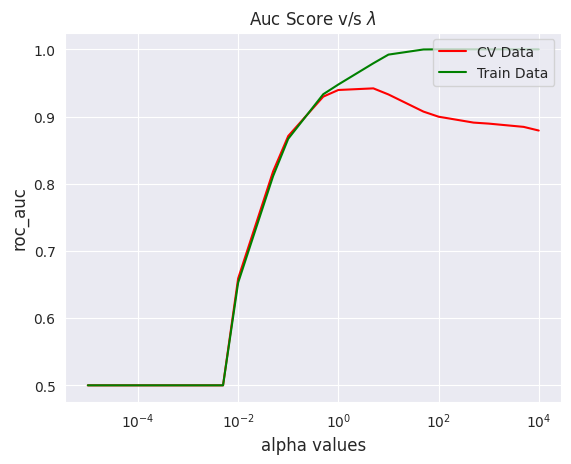

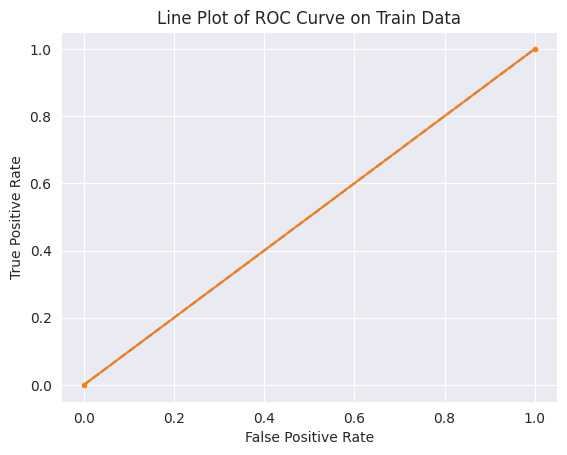

In [47]:
# find optimal C using l1 regularization 
logistic_l1(bow_train,bow_cv,Y_tr,Y_cv)

10000  for CV data auc score is -->  0.9096783828961048  and for train data auc score is -->  0.9962250597253762
5000  for CV data auc score is -->  0.9136549408635813  and for train data auc score is -->  0.9953991782236191
1000  for CV data auc score is -->  0.9137816002159815  and for train data auc score is -->  0.9959267216702262
500  for CV data auc score is -->  0.9140122293769279  and for train data auc score is -->  0.9980086284782824
100  for CV data auc score is -->  0.9281977896363354  and for train data auc score is -->  0.9937324384439743
50  for CV data auc score is -->  0.9345946613513778  and for train data auc score is -->  0.9916968449548984
10  for CV data auc score is -->  0.9437699251532262  and for train data auc score is -->  0.981393059097431
5  for CV data auc score is -->  0.945309511227016  and for train data auc score is -->  0.9748733884765413
1  for CV data auc score is -->  0.9413143564498618  and for train data auc score is -->  0.9553324904174353
0.5  

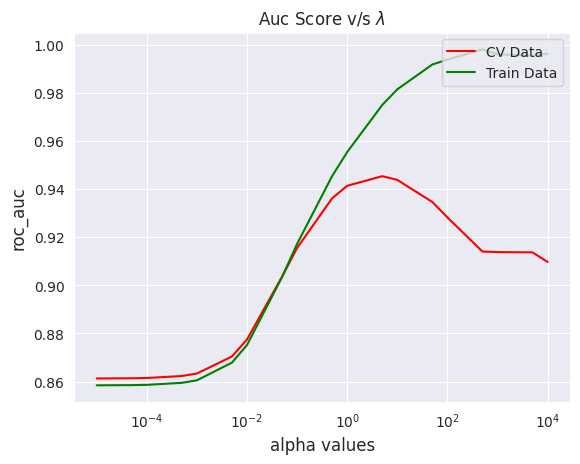

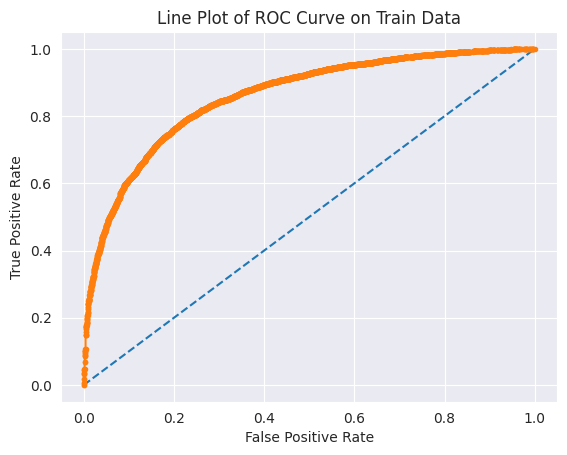

In [48]:
# find optimal C using l2 regularization 
logistic_l2(bow_train,bow_cv,Y_tr,Y_cv)

### LR simple CV Over the unseen or Test data in BoW

AUC Score 0.9346899673588713
macro f1 score for data : 0.8250445319876167
micro f1 scoore for data: 0.9093001841620626
hamming loss for data: 0.09069981583793739
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.77      0.65      0.70      2526
           1       0.93      0.96      0.95     12678

    accuracy                           0.91     15204
   macro avg       0.85      0.80      0.83     15204
weighted avg       0.91      0.91      0.91     15204



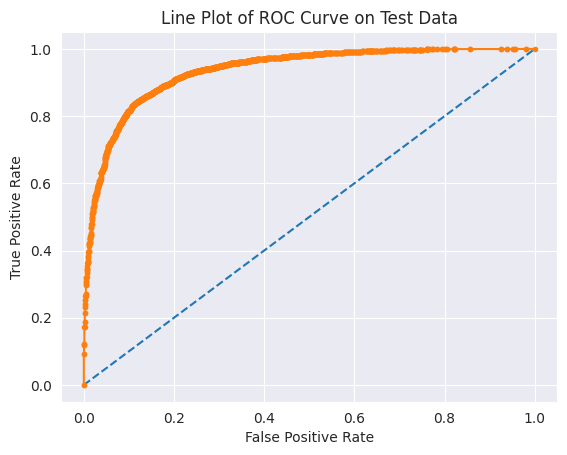

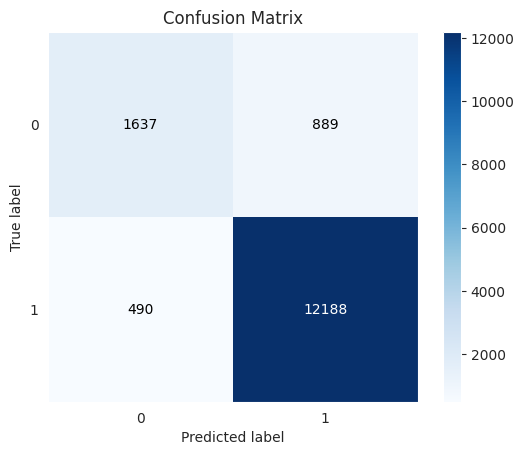

In [49]:
# optimal_C=5 for l1 regularization
testing_l1(bow_train,Y_tr,bow_test,Y_test,optimal_C=5)

AUC Score 0.936968370093167
macro f1 score for data : 0.8214548392102958
micro f1 scoore for data: 0.9108129439621152
hamming loss for data: 0.08918705603788477
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.80      0.61      0.70      2526
           1       0.93      0.97      0.95     12678

    accuracy                           0.91     15204
   macro avg       0.87      0.79      0.82     15204
weighted avg       0.91      0.91      0.91     15204



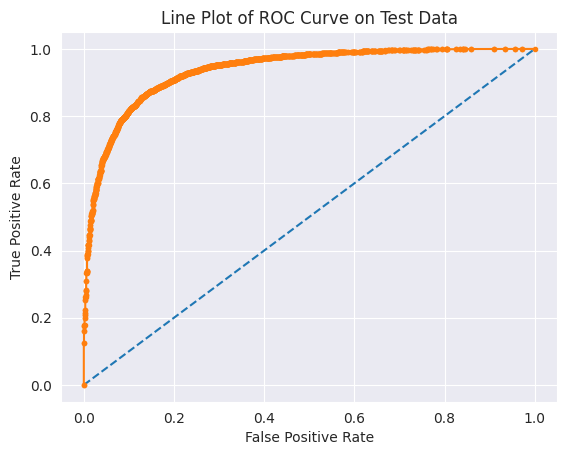

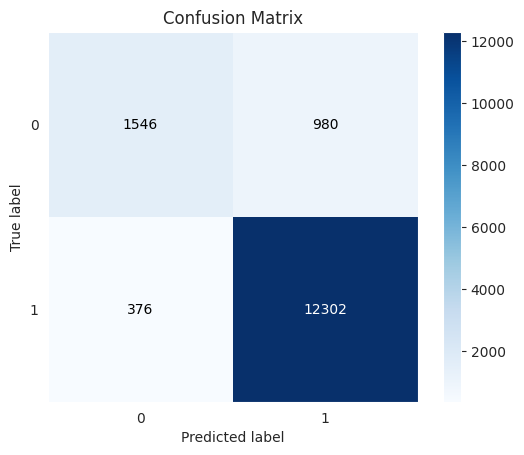

In [50]:
# optimal_C=5 for l2 regularization
testing_l2(bow_train,Y_tr,bow_test,Y_test,optimal_C=5)

In [52]:
#top 10 important feature for l1 regularization
clf1 = LogisticRegression(penalty='l1',C=5,solver='liblinear')
clf1.fit(bow_train,Y_tr)
imp_feature(count_vect,clf1)

			Negative						Positive
________________________________________________________________________________________________
	-18.0985	chart          				15.0087	skeptic        
	-16.7457	trash          				14.0014	cuisin         
	-14.7174	worst          				12.2056	barley         
	-14.3696	maggot         				11.8382	tad            
	-14.0797	undrink        				11.7402	downsid        
	-13.7706	cancel         				11.4816	recycl         
	-13.4940	nobodi         				11.3110	whenev         
	-12.9829	drug           				11.0533	perfect        
	-12.5701	aw             				10.9481	yum            
	-12.3999	terribl        				10.8774	delici         


In [53]:
#top 10 important feature for l2 regularization
clf2 = LogisticRegression(penalty='l2',C=5)
clf2.fit(bow_train,Y_tr)
imp_feature(count_vect,clf2)

			Negative						Positive
________________________________________________________________________________________________
	-8.1245	worst          				8.0615	delici         
	-7.7466	disappoint     				7.8354	perfect        
	-7.7189	terribl        				7.3256	excel          
	-7.3922	aw             				6.6505	best           
	-7.3839	return         				6.5155	nice           
	-7.2093	horribl        				6.2366	amaz           
	-5.9513	descript       				6.1004	great          
	-5.9062	threw          				5.6622	thank          
	-5.8393	cancel         				5.6211	favorit        
	-5.8308	wast           				5.5236	smooth         


### Sparsity using L1 Regularization

In [56]:
def sparsity(train_data,Y_train,test_data,Y_test):
    C_value = [1000,100,10,1,0.1,0.01,0.001,0.0001]
    for i in C_value[-8:]:
        lr = LogisticRegression(C=i,penalty='l1',solver='liblinear')
        lr.fit(train_data,Y_train)
        pred = lr.predict(test_data)
        print("C_value = ",i ," and l1_value = l1" )
        print("roc_auc score on test set: %0.3f%%"%(roc_auc_score(Y_test,pred)*100))
        print("Non Zero weights:",np.count_nonzero(lr.coef_))
        print("=+=+"*30)

In [57]:
sparsity(bow_train,Y_tr,bow_test,Y_test)

C_value =  1000  and l1_value = l1
roc_auc score on test set: 78.551%
Non Zero weights: 4272
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
C_value =  100  and l1_value = l1
roc_auc score on test set: 79.325%
Non Zero weights: 3954
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
C_value =  10  and l1_value = l1
roc_auc score on test set: 80.322%
Non Zero weights: 2607
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
C_value =  1  and l1_value = l1
roc_auc score on test set: 76.957%
Non Zero weights: 534
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
C_value =  0.1  and l1_value = l1
roc_auc score on test set: 58.778%
Non Zero weights: 69
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=

### Pertubation Test  on BoW

In [58]:
from scipy.sparse import find
logreg1 = LogisticRegression(C= 5, penalty= 'l2')
logreg1.fit(bow_train,Y_tr)
weights1 = find(logreg1.coef_[0])[2]  #Weights before adding random noise
print("Non Zero weights:",np.count_nonzero(logreg1.coef_))

Non Zero weights: 17391


In [59]:
bow_train_noise = bow_train
#Random noise
epsilon = np.random.uniform(low=-0.00001, high=0.00001, size=(find(bow_train_noise)[0].size))
a,b,c = find(bow_train)
bow_train_noise[a,b] = epsilon + bow_train[a,b]

In [60]:
logreg2 = LogisticRegression(C= 5, penalty= 'l2')
logreg2.fit(bow_train_noise,Y_tr)
print("Non Zero weights:",np.count_nonzero(logreg2.coef_))
weights2 = find(logreg2.coef_[0])[2]  #Weights after adding random noise

Non Zero weights: 17391


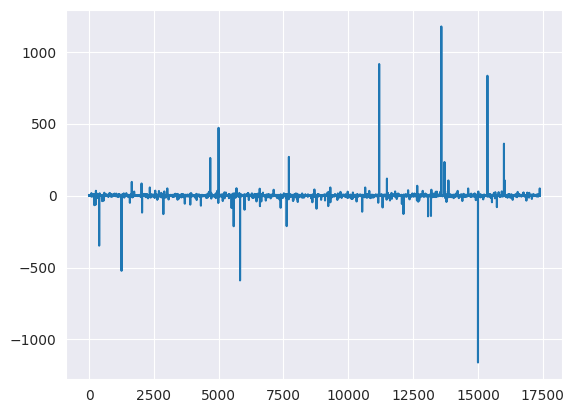

In [61]:
percentage_change_vector = (abs(weights1 - weights2)/weights1) * 100
plt.plot(percentage_change_vector)

In [62]:
print(percentage_change_vector[np.where(percentage_change_vector > 10)].size)

153


### Top 10 Collinear feature after Pertubation test

In [63]:
index = np.argsort(np.abs(weights1 - weights2))[::-1]
features = count_vect.get_feature_names()
features = np.array(features)
a = features[index]
print(a[:10])

['great' 'disappoint' 'refus' 'enjoy' 'neither' 'shame' 'vomit' 'odd'
 'fresh' 'rip']


##  TF-IDF

In [64]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (20680, 397694)
CV Data Size:  (10187, 397694)
Test Data Size:  (15204, 397694)


In [65]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
tfidf_train=preprocessing.normalize(tfidf_train)
tfidf_cv=preprocessing.normalize(tfidf_cv)
tfidf_test=preprocessing.normalize(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (20680, 397694)
CV Data Size:  (10187, 397694)
Test Data Size:  (15204, 397694)


10000  for CV data auc score is -->  0.9439314086473012  and for train data auc score is -->  1.0
5000  for CV data auc score is -->  0.9450093773874282  and for train data auc score is -->  1.0
1000  for CV data auc score is -->  0.9431265760616696  and for train data auc score is -->  1.0
500  for CV data auc score is -->  0.9422058544767332  and for train data auc score is -->  1.0
100  for CV data auc score is -->  0.9423340934809206  and for train data auc score is -->  1.0
50  for CV data auc score is -->  0.9432726220496412  and for train data auc score is -->  1.0
10  for CV data auc score is -->  0.9473376046160297  and for train data auc score is -->  0.9999025328949792
5  for CV data auc score is -->  0.9493761811487229  and for train data auc score is -->  0.9918113295904549
1  for CV data auc score is -->  0.9356797385245478  and for train data auc score is -->  0.9406245288661252
0.5  for CV data auc score is -->  0.9175382275732528  and for train data auc score is -->  0

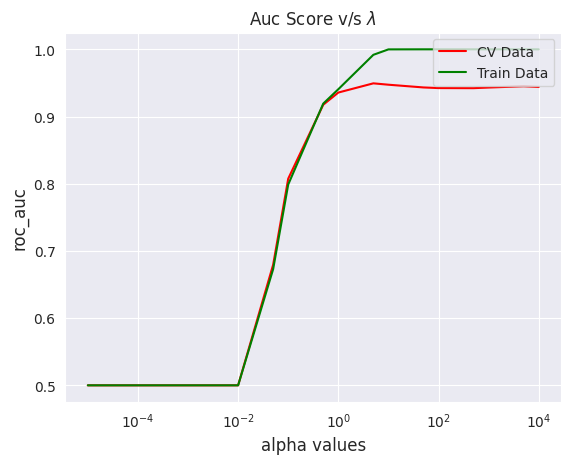

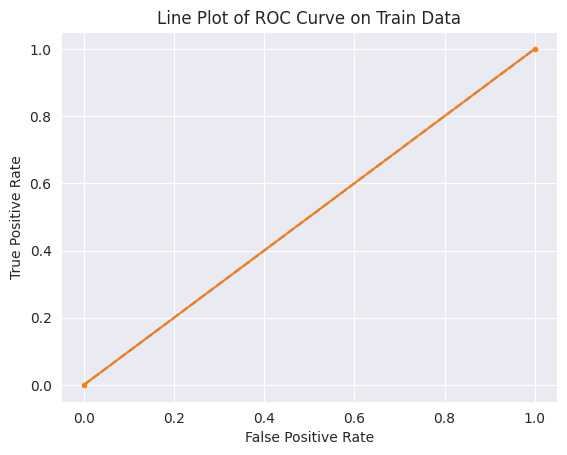

In [66]:
# find optimal_C using l1 regularization
logistic_l1(tfidf_train,tfidf_cv,Y_tr,Y_cv)

10000  for CV data auc score is -->  0.9542537150537943  and for train data auc score is -->  1.0
5000  for CV data auc score is -->  0.9546940788906824  and for train data auc score is -->  1.0
1000  for CV data auc score is -->  0.9547737795035873  and for train data auc score is -->  1.0
500  for CV data auc score is -->  0.9550440435639242  and for train data auc score is -->  1.0
100  for CV data auc score is -->  0.9553236419302771  and for train data auc score is -->  1.0
50  for CV data auc score is -->  0.95554859870526  and for train data auc score is -->  1.0
10  for CV data auc score is -->  0.955378068114585  and for train data auc score is -->  0.9999988531297558
5  for CV data auc score is -->  0.9546405143346219  and for train data auc score is -->  0.9998440425125236
1  for CV data auc score is -->  0.9484822418418165  and for train data auc score is -->  0.990122006586442
0.5  for CV data auc score is -->  0.9433656779003843  and for train data auc score is -->  0.979

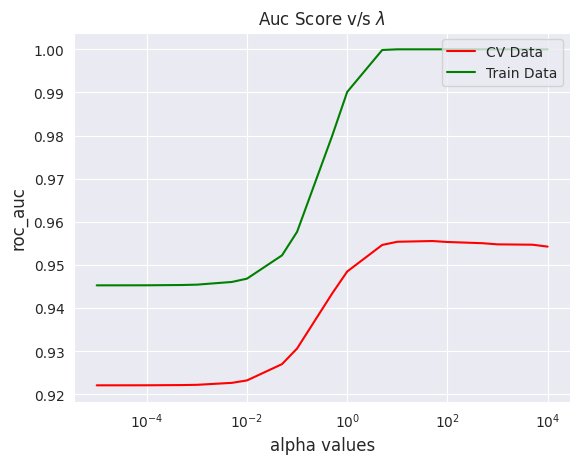

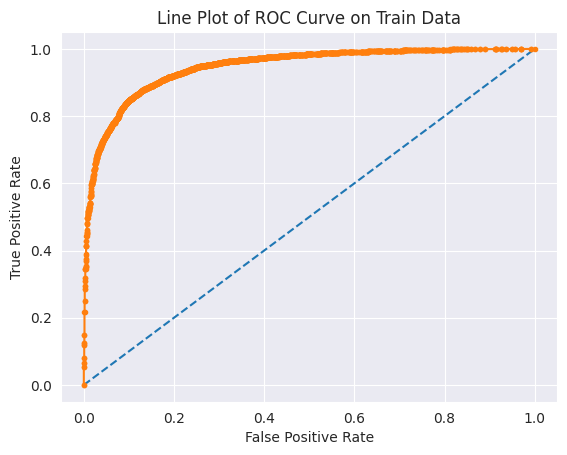

In [67]:
# find optimal_C using l2 regularization
logistic_l2(tfidf_train,tfidf_cv,Y_tr,Y_cv)

###  Logistic Regression Over the unseen or Test data in TF-IDF

AUC Score 0.9421427471382338
macro f1 score for data : 0.8392972068795652
micro f1 scoore for data: 0.9156800841883714
hamming loss for data: 0.08431991581162852
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.78      0.68      0.73      2526
           1       0.94      0.96      0.95     12678

    accuracy                           0.92     15204
   macro avg       0.86      0.82      0.84     15204
weighted avg       0.91      0.92      0.91     15204



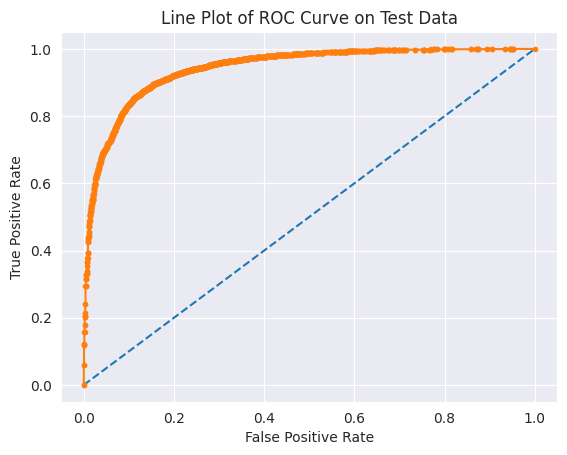

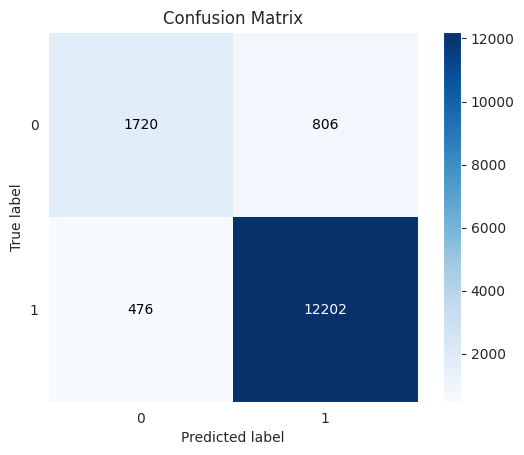

In [68]:
testing_l1(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_C=5)

AUC Score 0.9480463129813718
macro f1 score for data : 0.8337979237412227
micro f1 scoore for data: 0.9177847934754012
hamming loss for data: 0.0822152065245988
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.84      0.62      0.72      2526
           1       0.93      0.98      0.95     12678

    accuracy                           0.92     15204
   macro avg       0.88      0.80      0.83     15204
weighted avg       0.91      0.92      0.91     15204



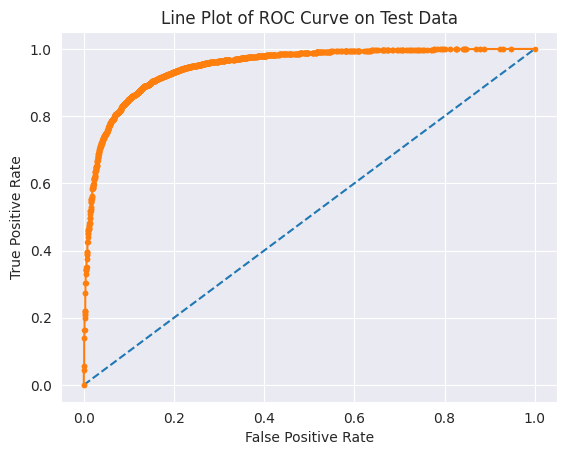

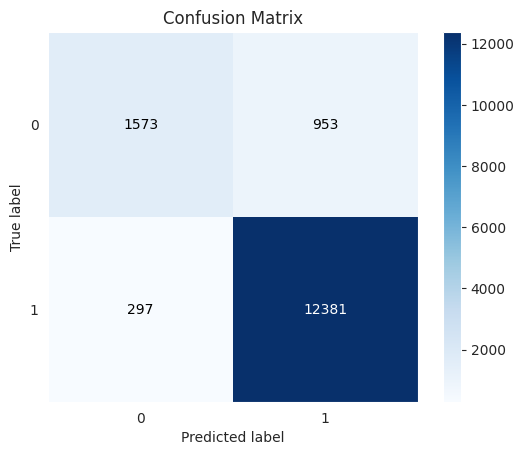

In [69]:
testing_l2(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_C=50)

In [71]:
clf1=LogisticRegression(penalty='l1',C=5,solver='liblinear')
clf1.fit(tfidf_train,Y_tr)
imp_feature(tf_idf_vect,clf1)

			Negative						Positive
________________________________________________________________________________________________
	-25.6287	two star       				26.1864	delici         
	-23.0906	watcher brand  				26.1828	great          
	-21.3614	wont buy       				25.5210	best           
	-21.1511	high hope      				24.2902	perfect        
	-21.0102	disappoint     				22.6273	love           
	-20.8614	worst          				21.3020	high recommend 
	-20.3361	aw             				19.9085	excel          
	-19.6223	terribl        				19.7167	nice           
	-18.9143	return         				17.4901	favorit        
	-18.2637	horribl        				17.3908	thank          


In [72]:
clf2=LogisticRegression(penalty='l2',C=50)
clf2.fit(tfidf_train,Y_tr)
imp_feature(tf_idf_vect,clf2)

			Negative						Positive
________________________________________________________________________________________________
	-19.4082	disappoint     				20.9296	great          
	-14.0320	return         				20.0580	love           
	-13.5437	terribl        				17.4013	delici         
	-13.4154	worst          				17.1205	best           
	-13.1189	horribl        				15.5413	perfect        
	-12.6974	aw             				14.1575	good           
	-11.0611	threw          				14.1128	nice           
	-10.5285	thought        				13.1920	excel          
	-10.3611	wast           				12.3847	favorit        
	-10.0243	wont buy       				10.5540	thank          


## Avg W2V

In [73]:
i=0
list_of_sent_train=[]
for sent in X_tr.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [74]:
i=0
list_of_sent_CV=[]
for sent in X_cv.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_CV.append(filtered_sentence)

In [75]:
i=0
list_of_sent_test=[]
for sent in X_test.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [80]:
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sent_train,min_count=5,vector_size=50,workers=4)
w2v_words = list(w2v_model.wv.index_to_key)

In [81]:
def avg_w2v(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)        
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [82]:
train_avgw2v = avg_w2v(list_of_sent_train)

20680
50


In [83]:
cv_avgw2v = avg_w2v(list_of_sent_CV)

10187
50


In [84]:
test_avgw2v = avg_w2v(list_of_sent_test)

15204
50


In [85]:
normalizer = preprocessing.Normalizer()
train_avgw2v = normalizer.fit_transform(train_avgw2v)
cv_avgw2v = normalizer.transform(cv_avgw2v)
test_avgw2v = normalizer.transform(test_avgw2v)

10000  for CV data auc score is -->  0.8968254743263504  and for train data auc score is -->  0.8909322518616781
5000  for CV data auc score is -->  0.89682583333812  and for train data auc score is -->  0.8909327409681059
1000  for CV data auc score is -->  0.8968190839168471  and for train data auc score is -->  0.8909290979685066
500  for CV data auc score is -->  0.896826048745182  and for train data auc score is -->  0.890933314403228
100  for CV data auc score is -->  0.8968259769428282  and for train data auc score is -->  0.8909344781392112
50  for CV data auc score is -->  0.8968379679359408  and for train data auc score is -->  0.8909402968191267
10  for CV data auc score is -->  0.8969050313345472  and for train data auc score is -->  0.8909578371875678
5  for CV data auc score is -->  0.8969609653682886  and for train data auc score is -->  0.8909762545744311
1  for CV data auc score is -->  0.8970914302454491  and for train data auc score is -->  0.8908041734405798
0.5  fo

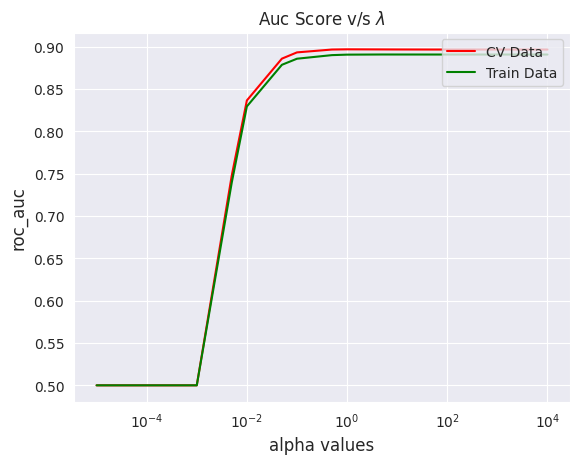

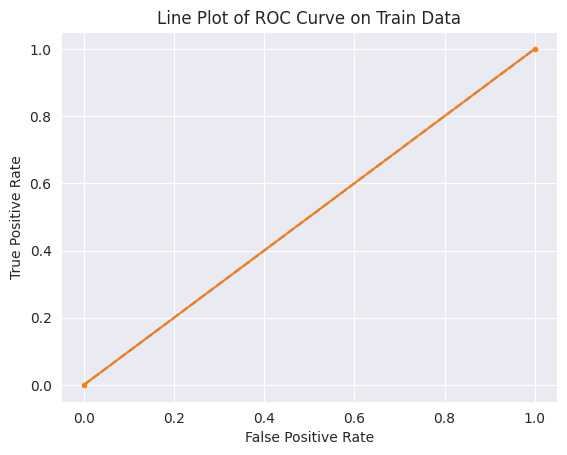

In [86]:
# find optimal_C using l1 regularization
logistic_l1(train_avgw2v,cv_avgw2v,Y_tr,Y_cv)

10000  for CV data auc score is -->  0.8968240382792709  and for train data auc score is -->  0.8909337697781778
5000  for CV data auc score is -->  0.8968375371218171  and for train data auc score is -->  0.8909429278743929
1000  for CV data auc score is -->  0.8968199455450947  and for train data auc score is -->  0.8909313579775172
500  for CV data auc score is -->  0.8968312185146677  and for train data auc score is -->  0.8909347142595556
100  for CV data auc score is -->  0.8968407682277456  and for train data auc score is -->  0.8909373284490829
50  for CV data auc score is -->  0.8968592214327156  and for train data auc score is -->  0.890945137286187
10  for CV data auc score is -->  0.8970230744044714  and for train data auc score is -->  0.8909707226120765
5  for CV data auc score is -->  0.8971362349143254  and for train data auc score is -->  0.8909353382918943
1  for CV data auc score is -->  0.8971050008903492  and for train data auc score is -->  0.8902316996655812
0.5 

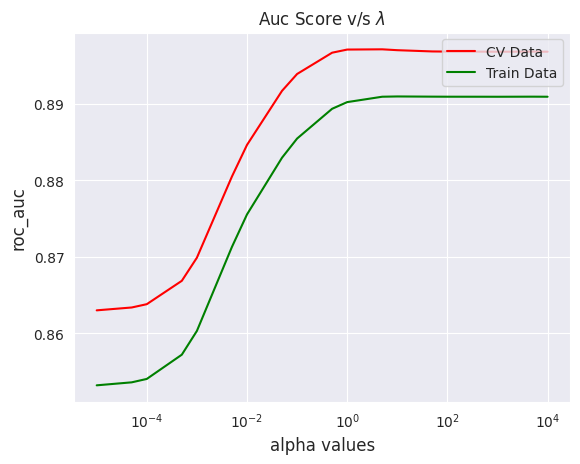

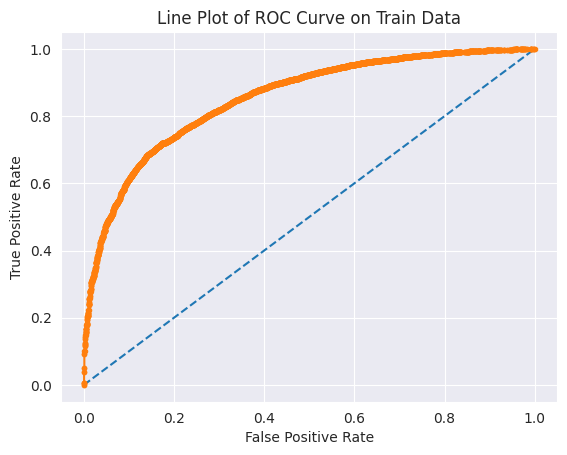

In [87]:
# find optimal_C using l2 regularization
logistic_l2(train_avgw2v,cv_avgw2v,Y_tr,Y_cv)

AUC Score 0.8859037956662603
macro f1 score for data : 0.7271958111097974
micro f1 scoore for data: 0.8743093922651933
hamming loss for data: 0.12569060773480664
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.70      0.42      0.53      2526
           1       0.89      0.96      0.93     12678

    accuracy                           0.87     15204
   macro avg       0.80      0.69      0.73     15204
weighted avg       0.86      0.87      0.86     15204



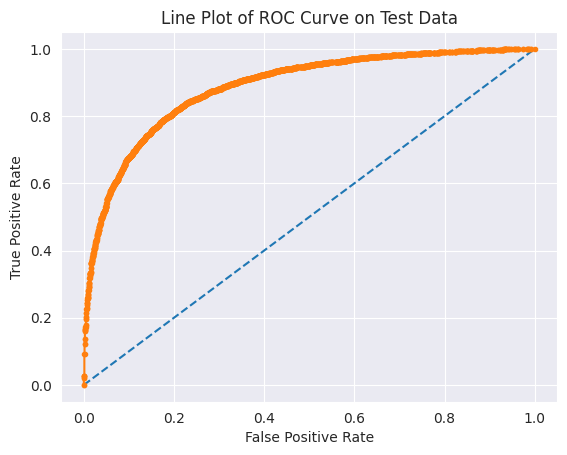

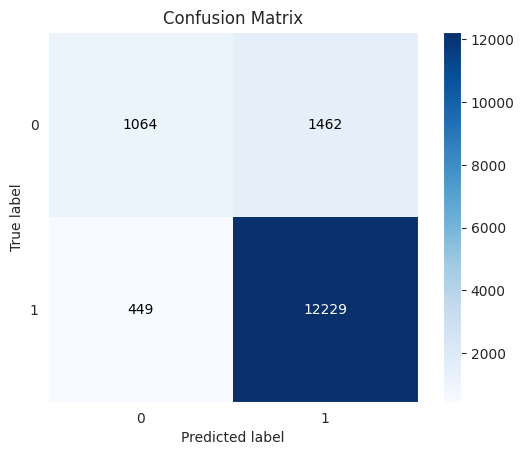

In [88]:
testing_l1(train_avgw2v,Y_tr,test_avgw2v,Y_test,optimal_C=0.5)

AUC Score 0.8855414807628679
macro f1 score for data : 0.7210001916428956
micro f1 scoore for data: 0.8742436200999737
hamming loss for data: 0.1257563799000263
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.72      0.40      0.51      2526
           1       0.89      0.97      0.93     12678

    accuracy                           0.87     15204
   macro avg       0.80      0.68      0.72     15204
weighted avg       0.86      0.87      0.86     15204



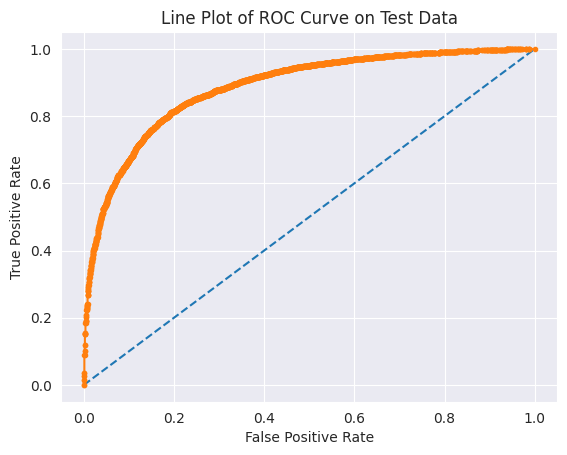

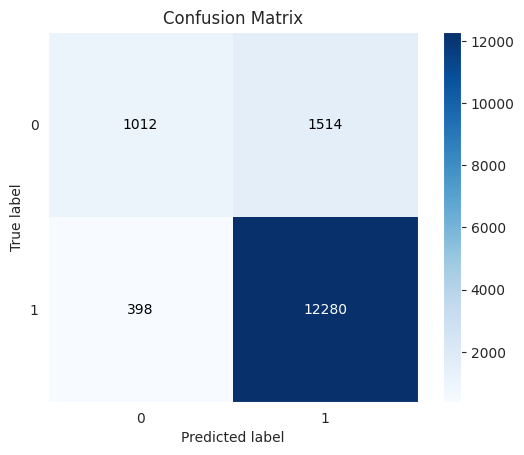

In [89]:
testing_l2(train_avgw2v,Y_tr,test_avgw2v,Y_test,optimal_C=0.5)

## TF-IDF Weighted W2V

In [90]:
tf_idf_vect = TfidfVectorizer()
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (20680, 17391)
CV Data Size:  (10187, 17391)
Test Data Size:  (15204, 17391)


In [91]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))
#return tfidf_sent_vectors_train

20680
50


In [92]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_CV:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_cv[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_CV))
print(len(tfidf_sent_vectors_CV[0]))
#return tfidf_sent_vectors_CV

10187
50


In [93]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))
#return tfidf_sent_vectors_test

15204
50


In [94]:
train_tfidfw2v = tfidf_sent_vectors_train
cv_tfidfw2v = tfidf_sent_vectors_CV
test_tfidfw2v = tfidf_sent_vectors_test

In [95]:
normalizer = preprocessing.Normalizer()
train_tfidfw2v = normalizer.fit_transform(train_tfidfw2v)
cv_tfidfw2v = normalizer.transform(cv_tfidfw2v)
test_tfidfw2v = normalizer.transform(test_tfidfw2v)

10000  for CV data auc score is -->  0.8717301208002802  and for train data auc score is -->  0.867108990907832
5000  for CV data auc score is -->  0.8717219353319279  and for train data auc score is -->  0.8671049599962383
1000  for CV data auc score is -->  0.8717311260332358  and for train data auc score is -->  0.867107220005249
500  for CV data auc score is -->  0.8717325620803152  and for train data auc score is -->  0.8671080632921933
100  for CV data auc score is -->  0.8717225815531138  and for train data auc score is -->  0.8671034589454774
50  for CV data auc score is -->  0.8717378754545089  and for train data auc score is -->  0.8671044371583329
10  for CV data auc score is -->  0.8717697556996707  and for train data auc score is -->  0.8671071525422934
5  for CV data auc score is -->  0.8718213097898201  and for train data auc score is -->  0.8670881954517858
1  for CV data auc score is -->  0.8716143036033293  and for train data auc score is -->  0.866522973944508
0.5  f

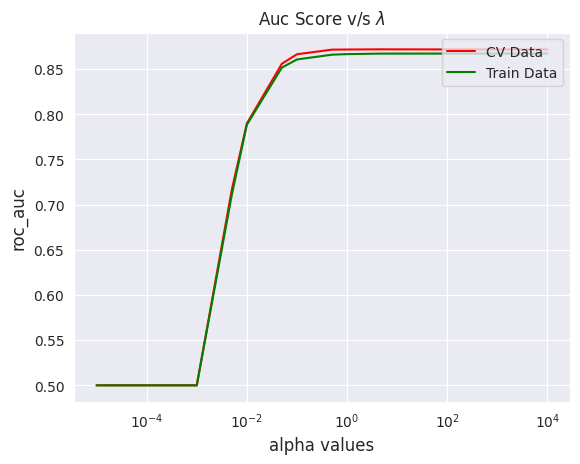

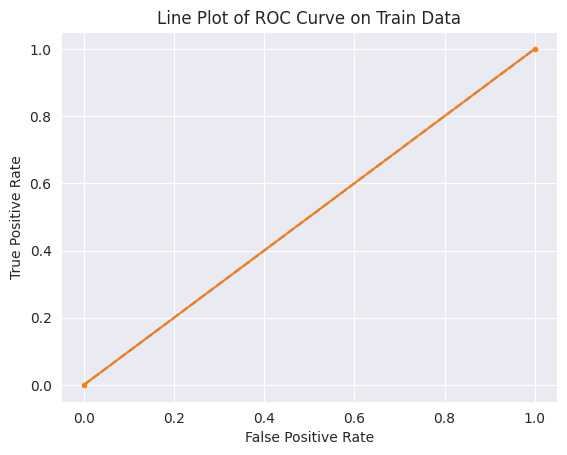

In [96]:
# find optimal_C using l1 regularization
logistic_l1(train_tfidfw2v,cv_tfidfw2v,Y_tr,Y_cv)

10000  for CV data auc score is -->  0.8717207864942644  and for train data auc score is -->  0.8670972523535674
5000  for CV data auc score is -->  0.8717118112000184  and for train data auc score is -->  0.8671075910515045
1000  for CV data auc score is -->  0.8717294027767406  and for train data auc score is -->  0.8671054996998826
500  for CV data auc score is -->  0.8717310542308818  and for train data auc score is -->  0.8671081476208876
100  for CV data auc score is -->  0.8717469225511089  and for train data auc score is -->  0.8671172382541472
50  for CV data auc score is -->  0.8717500818546836  and for train data auc score is -->  0.8671243555959569
10  for CV data auc score is -->  0.8718103958320169  and for train data auc score is -->  0.8670955826454178
5  for CV data auc score is -->  0.8717873472763931  and for train data auc score is -->  0.8670120466407167
1  for CV data auc score is -->  0.8709879716696632  and for train data auc score is -->  0.8658632368365142
0.5

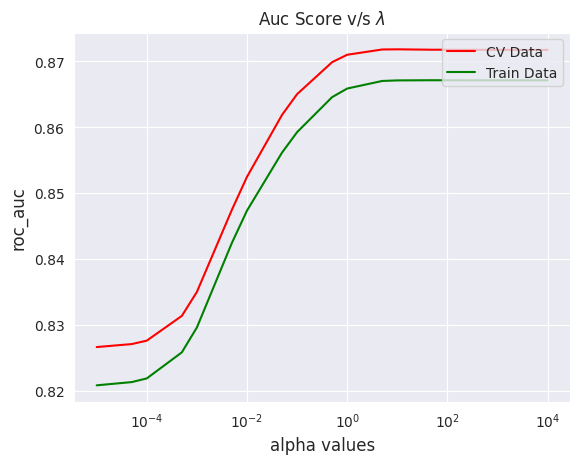

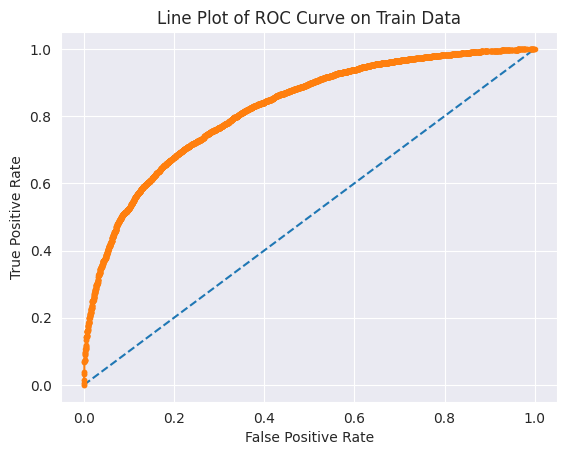

In [97]:
# find optimal_C using l1 regularization
logistic_l2(train_tfidfw2v,cv_tfidfw2v,Y_tr,Y_cv)

AUC Score 0.8567509824001702
macro f1 score for data : 0.6605632988223332
micro f1 scoore for data: 0.8602341489081821
hamming loss for data: 0.13976585109181794
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.70      0.28      0.40      2526
           1       0.87      0.98      0.92     12678

    accuracy                           0.86     15204
   macro avg       0.78      0.63      0.66     15204
weighted avg       0.84      0.86      0.83     15204



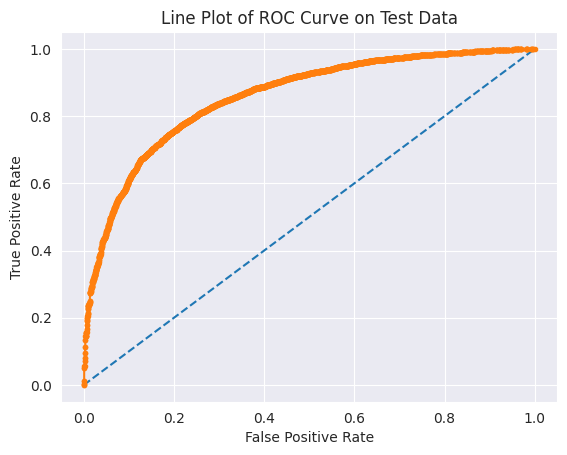

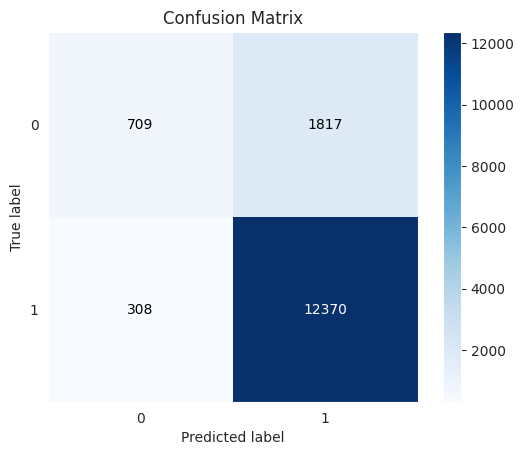

In [98]:
testing_l1(train_tfidfw2v,Y_tr,test_tfidfw2v,Y_test,optimal_C=0.1)

AUC Score 0.8591896992527126
macro f1 score for data : 0.6815935430625472
micro f1 scoore for data: 0.8647724283083399
hamming loss for data: 0.13522757169166008
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.71      0.32      0.44      2526
           1       0.88      0.97      0.92     12678

    accuracy                           0.86     15204
   macro avg       0.79      0.65      0.68     15204
weighted avg       0.85      0.86      0.84     15204



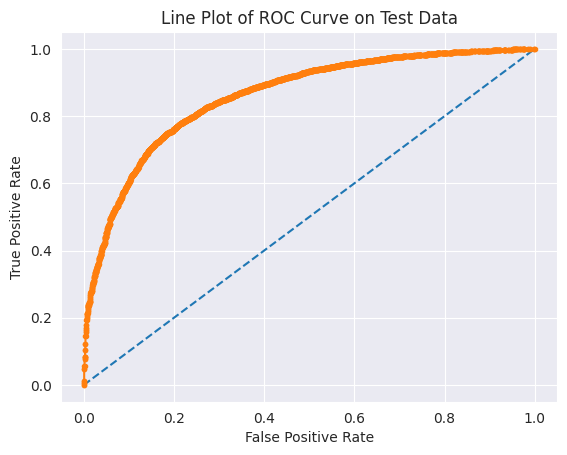

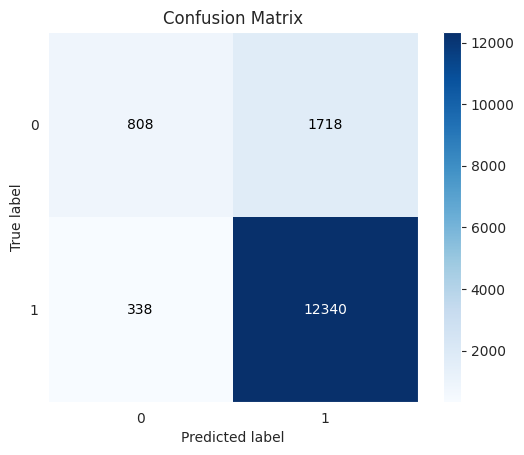

In [99]:
testing_l2(train_tfidfw2v,Y_tr,test_tfidfw2v,Y_test,optimal_C=0.5)

In [100]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Regularization", "Best Hyper Parameter(C)","Test Auc Score"]
x.add_row(["BoW","L1",5,94.84])
x.add_row(["BoW","L2",5,95.02])
x.add_row(["Tf-Idf","L1",5,95.88])
x.add_row(["Tf-Idf","L2",50,96.23])
x.add_row(["Avg-W2V","L1",0.5,91.31])
x.add_row(["Avg-W2V","L2",0.5,91.32])
x.add_row(["TfIdf-W2V","L1",0.1,88.72])
x.add_row(["TfIdf-W2V","L2",0.5,88.73])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+------------+----------------+-------------------------+----------------+
| Vectorizer | Regularization | Best Hyper Parameter(C) | Test Auc Score |
+------------+----------------+-------------------------+----------------+
|    BoW     |       L1       |            5            |     94.84      |
|    BoW     |       L2       |            5            |     95.02      |
|   Tf-Idf   |       L1       |            5            |     95.88      |
|   Tf-Idf   |       L2       |            50           |     96.23      |
|  Avg-W2V   |       L1       |           0.5           |     91.31      |
|  Avg-W2V   |       L2       |           0.5           |     91.32      |
| TfIdf-W2V  |       L1       |           0.1           |     88.72      |
| TfIdf-W2V  |       L2       |           0.5           |     88.73      |
+------------+----------------+-------------------------+----------------+
